1. Import library (opencv? numpy?)
2. Upload images
3. Convert to grayscale
4. Run code to find area of each in pixels
5. Convert to mm
6. Insert into array based on dimensions of electrode
7. Insert into histogram based on radius


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Binary Threshold')

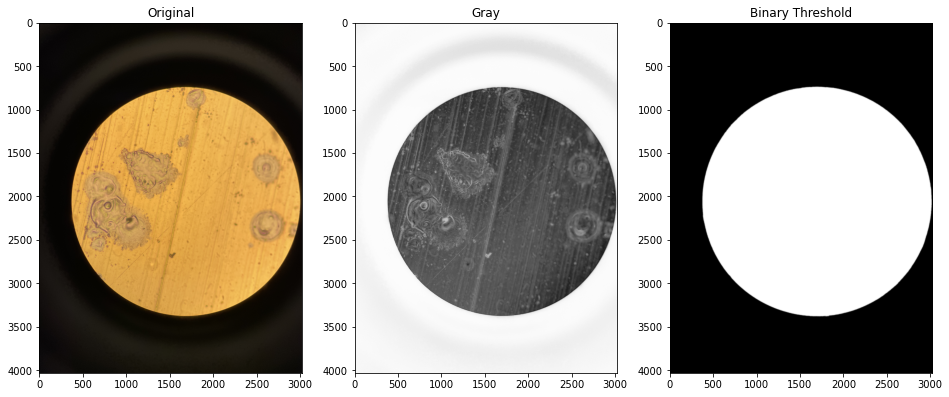

In [2]:
src = cv2.imread('Gold Set 2/y0_x2.JPG')
original = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
imgray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
_,alpha = cv2.threshold(imgray,55,255,cv2.THRESH_BINARY_INV)
alpha = cv2.GaussianBlur(alpha, (21,21), cv2.BORDER_DEFAULT)


rows = 1
columns = 3
fig = plt.figure(figsize=(16,9))
fig.add_subplot(rows, columns, 1)
plt.imshow(original)
plt.title("Original")
fig.add_subplot(rows, columns, 2)
plt.imshow(imgray, cmap='Greys')
plt.title("Gray")
fig.add_subplot(rows, columns, 3)
plt.imshow(alpha, cmap='Greys')
plt.title("Binary Threshold")


In [3]:
circle = cv2.HoughCircles(alpha, cv2.HOUGH_GRADIENT, 1.5, 100)
print('I have found ' + str(len(circle)) + ' circle(s).')
roundcircle = np.round(circle[0, 0,:])
(x,y) = (int(roundcircle[0]), int(roundcircle[1]))
r = int(roundcircle[2])
circlearea = np.pi*r**2
print('Center at (' + str(x) +', '+ str(y) + ')')
print('Radius = '+str(r))
print('Circle Area = ' + str(circlearea))

I have found 1 circle(s).
Center at (1690, 2060)
Radius = 1316
Circle Area = 5440786.086675405


In [4]:
circlemask = np.zeros(original.shape, dtype=np.uint8)
cv2.circle(circlemask, (x,y), r, (255,255,255), -1)
circlemask = cv2.cvtColor(circlemask,cv2.COLOR_BGR2GRAY)
ROI = cv2.bitwise_and(original,original, mask=circlemask)

The contour area is 5563104.0


Text(0.5, 1.0, 'ROI Contour')

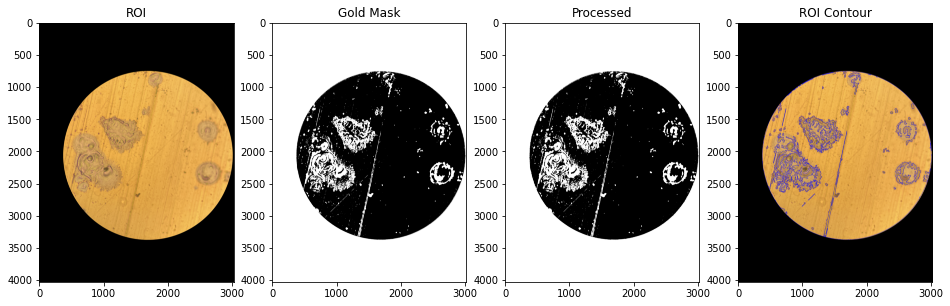

In [5]:
rows = 1
columns = 4
fig = plt.figure(figsize=(16,9))
fig.add_subplot(rows, columns, 1)
plt.imshow(ROI)
plt.title("ROI")

hsvimage = cv2.cvtColor(ROI, cv2.COLOR_RGB2HSV)
lower = np.array([15, 115, 200], dtype="uint8")
upper = np.array([76, 200, 250], dtype="uint8")
goldmask = cv2.inRange(hsvimage, lower, upper)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(goldmask, cv2.MORPH_OPEN, kernel, iterations=1)

cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
area = 0
for c in cnts:
    currcontour = cv2.contourArea(c)
    if currcontour >= 500:
        area += currcontour
        cv2.drawContours(ROI,[c], 0, (0,0,255), 2)
print('The contour area is ' + str(area))

fig.add_subplot(rows, columns, 2)
plt.imshow(goldmask, cmap='Greys')
plt.title("Gold Mask")
fig.add_subplot(rows, columns, 3)
plt.imshow(opening, cmap='Greys')
plt.title("Processed")
fig.add_subplot(rows, columns, 4)
plt.imshow(ROI)
plt.title("ROI Contour")

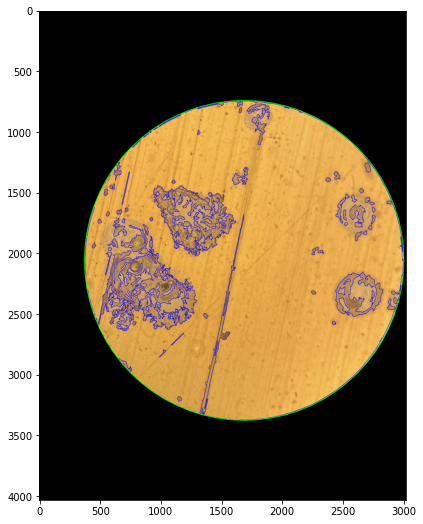

In [6]:
fig = plt.figure(figsize=(16,9))
cv2.circle(ROI, (x,y),r,(0,255,0), 5)
plt.imshow(ROI)

In [7]:
#Calculating Area:
number_of_black_pix = np.sum(opening == 0)      # extracting only black pixels
print('Number of black pixels: ' + str(number_of_black_pix))
perarea = area/circlearea
print('Contour area/Circle area = '+ str(area)+'/'+ str(circlearea)+' = ' +str(perarea))

Number of black pixels: 7370146
Contour area/Circle area = 5563104.0/5440786.086675405 = 1.0224816619098762


In [8]:
hsvalue = cv2.cvtColor(np.uint8([[[218,160,75]]]),cv2.COLOR_RGB2HSV)
print(str(hsvalue))

[[[ 18 167 218]]]
